#Модуль 2. Диффузионные модели. Часть 2
## Домашнее задание: реализация обучения диффузионной модели

###Цель домашнего занятия
Научиться реализовывать обучение диффузии под датасет и решить задачу Image Inpainting

###Рекомендации
Задания можно реализовать как с адаптерами так и без. Предполагается, что вы  решите задания с помощью accelerate.

### [6 баллов] Дообучение диффузионной модели.

В этом задании вам предстоит обучить диффузионную модель для решения задачи text-to-image. В предыдущем задании вы уже обучали диффузионную модель, но она была unconditional, то есть генерировала без каких-либо условий. В этот раз вам предлагается обучить свою text-to-image модель на датасете https://huggingface.co/datasets/Norod78/cartoon-blip-captions или на другом понравившемся датасете

---

В этой части задания вам рекомендуется взять код с семинара 4 и адаптировать его под обучение на новом датасете, с учетом того, что в нём содержаться картинки

**Ожидаемый результат**

В качестве результатов модели, от вас требуется предоставить визуализации генераций, полученных от вашей модели и код обучения модели, а также визуальное сравнение качества моделей до и после дообучения. Если не получится дообучить, то можно провести сравнение уже обученных адаптеров (3 балла).

В первой задаче реализовано дообучение Stable Diffusion1.5 с помощью адаптера Dreambooth на датасете из 5 изображений интерьера, взятых из Интернета. Процесс обучения представлен [в этом блокноте](https://colab.research.google.com/drive/19OZB1e9YHHvXMM7q0deKjwWVF6yVjZXk?usp=drive_link). Визуализация результатов дана ниже.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def image_grid(imgs, rows, cols):

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

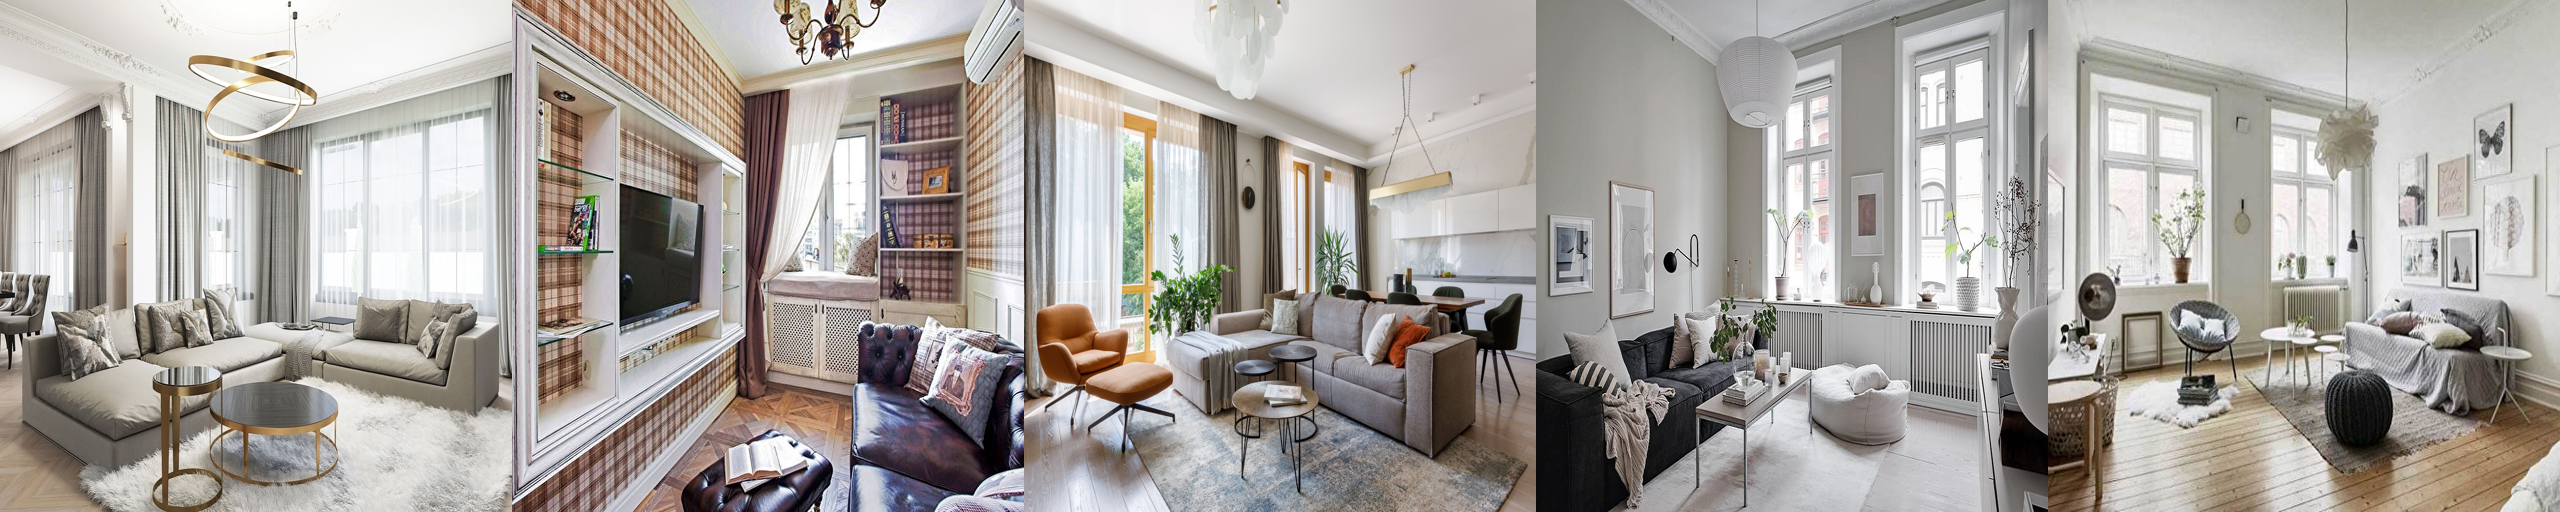

In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/СММО SF/HW2_Images/'

from PIL import Image
import glob

images = []
for file in glob.glob(f'{image_path}*'):
  if not 'caption' in file:
    img = Image.open(file).resize((512,512))
    images.append(img)
  else:
    continue

image_grid(images, 1, len(images))

5-я эпоха

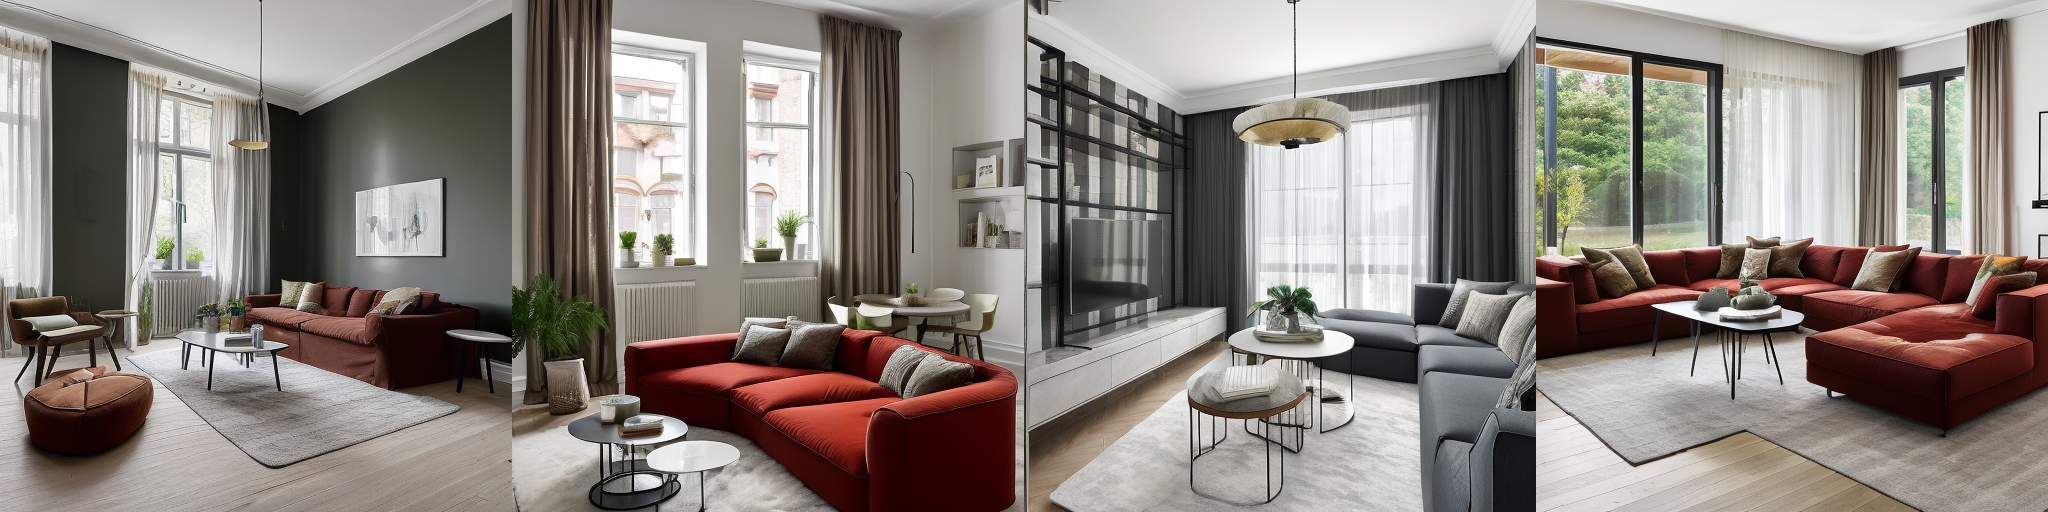

In [ ]:
output_path = '/content/drive/MyDrive/Colab Notebooks/СММО SF/LoRA/output/out_images_22_40/'
out_images = []
for file in glob.glob(f'{output_path}*'):
    img = Image.open(file).resize((512,512))
    out_images.append(img)

image_grid(out_images, 1, len(out_images))

10-я эпоха

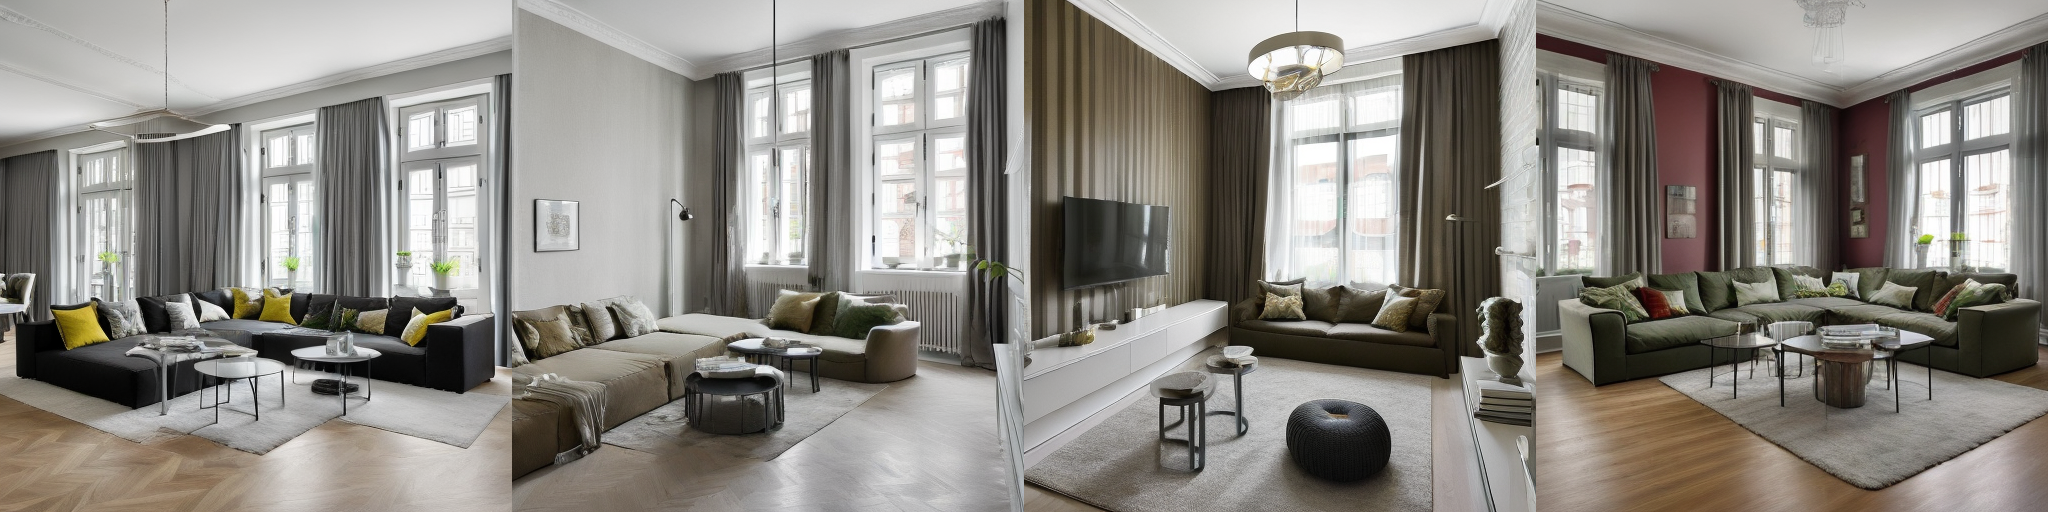

In [ ]:
output_path = '/content/drive/MyDrive/Colab Notebooks/СММО SF/LoRA/output/out_images_22_30/'
out_images = []
for file in glob.glob(f'{output_path}*'):
    img = Image.open(file).resize((512,512))
    out_images.append(img)

image_grid(out_images, 1, len(out_images))

20-я эпоха

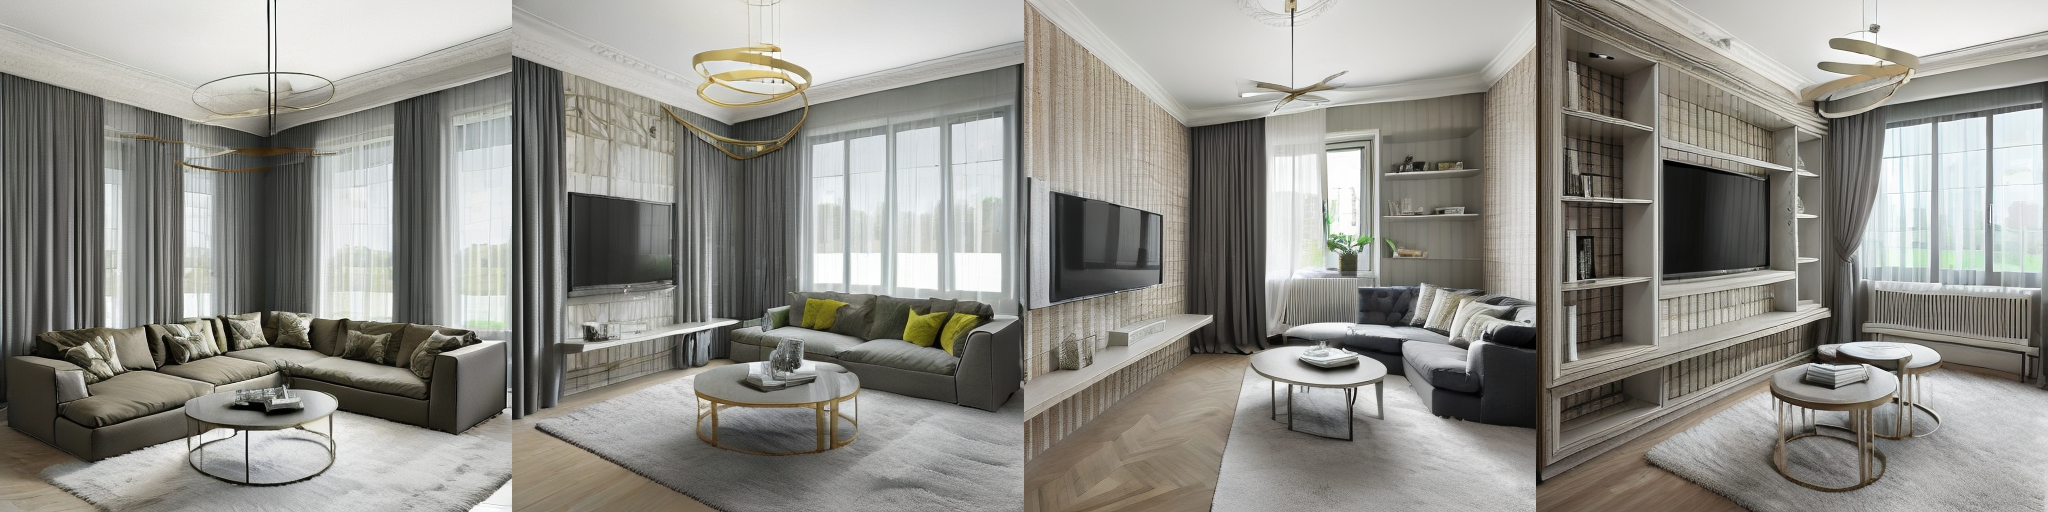

In [ ]:
output_path = '/content/drive/MyDrive/Colab Notebooks/СММО SF/LoRA/output/out_images_22_15/'
out_images = []
for file in glob.glob(f'{output_path}*'):
    img = Image.open(file).resize((512,512))
    out_images.append(img)

image_grid(out_images, 1, len(out_images))

# Вывод: с увеличением количества эпох генерация стала более стандартизированной, оригинальность уменьшилась.

### [4 балла] Image Inpainting
В первой части задания (2 балла) вам предстоит обучить диффузионную модель решать задачу image inpainting. Для этого вам необходимо модифицировать код из семинара 2 следующий образом:
- Реализовать функцию генерации маски, можно использовать приведенную ниже или реализовать свою.
- Добавить в UNet новых 4 канала, куда подавать замаскированное изображение и маску
- Запустить обучение

---

**Ожидаемый результат**

В качестве результатов модели, от вас требуется предоставить визуализации генераций, полученных от вашей модели и код обучения модели.

In [ ]:
import numpy as np

class RectangleGenerator:
    """
    Generates for each object a mask where unobserved region is
    a rectangle which square divided by the image square is in
    interval [min_rect_rel_square, max_rect_rel_square].
    """
    def __init__(self, min_rect_rel_square=0.3, max_rect_rel_square=1):
        self.min_rect_rel_square = min_rect_rel_square
        self.max_rect_rel_square = max_rect_rel_square

    def gen_coordinates(self, width, height):
        x1, x2 = np.random.randint(0, width, 2)
        y1, y2 = np.random.randint(0, height, 2)
        x1, x2 = min(x1, x2), max(x1, x2)
        y1, y2 = min(y1, y2), max(y1, y2)
        return int(x1), int(y1), int(x2), int(y2)

    def __call__(self, batch):
        batch_size, num_channels, width, height = batch.shape
        mask = torch.zeros_like(batch)
        for i in range(batch_size):
            x1, y1, x2, y2 = self.gen_coordinates(width, height)
            sqr = width * height
            while not (self.min_rect_rel_square * sqr <=
                       (x2 - x1 + 1) * (y2 - y1 + 1) <=
                       self.max_rect_rel_square * sqr):
                x1, y1, x2, y2 = self.gen_coordinates(width, height)
            mask[i, :, x1: x2 + 1, y1: y2 + 1] = 1
        return mask

Во второй части задания (2 балла) вам предстоит провизуализировать результаты полученной модели inpainting и модели SD через [демо](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/in_painting_with_stable_diffusion_using_diffusers.ipynb#scrollTo=R596bpT2ynqV). Пример демо реализован по ссылке. Если у вас не получится реализовать модель из первого задания, то вы можете использовать модель SD и получите один балл

**Ожидаемый результат**

От вас ожидается анализ кейсов, когда модель отрабатывает хорошо (например, определенный тип масок), а когда плохо.

Задача 2.2 реализована [в этом ноутбуке](https://colab.research.google.com/drive/1uqIaMmTnTow-eYeFpuue7Cmk8b0z1Mhx?usp=sharing). Для получения маски применена семантико-паноптическая сегментация модели MaskFormer, затем эта маска подается на изображение из датасета первой задачи. Значимых результатов достичь не удалось: модель понимает маску, но не заменяет ее желаемым объектом